In [5]:
!pip install transformers
import collections
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import string
puncs = string.punctuation.replace('*', '').replace('#', '')
table = str.maketrans('', '', puncs)
import re
# from nltk.stem.porter import PorterStemmer
# porter = PorterStemmer()

import torch
import torch.nn as nn

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
from transformers import GPT2Tokenizer, GPT2Model, GPT2Config
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', add_prefix_space=True)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
gpt2_config = GPT2Config(vocab_size=tokenizer.vocab_size)
gpt2_model = GPT2Model.from_pretrained('gpt2', config=gpt2_config)
gpt2_model.resize_token_embeddings(len(tokenizer))

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(50258, 768)

In [7]:
print(tokenizer.vocab_size)
print(tokenizer.pad_token)
# tokenizer.vocab_size += 1
# gpt2_model.config.vocab_size += 1
print(gpt2_model.config.vocab_size)


50257
[PAD]
50258


In [8]:
def checks(w):
    if w in stop_words: return False
    if re.search('[a-zA-Z]', w) and '*' in w: return True
    if not w.isalpha(): return False
    if len(w) == 1 and w not in ['a', 'i', 'o', 'u']: return False
    return True

In [9]:
def getWordCounts(texts, scores, word_tokens):
  l = len(texts)
  wordCounts = {}
  for i in range(l):
    if i % 10000 == 0: print(i)
    text, score = texts[i], scores[i]
    wtoks = word_tokens[i]
    for w in wtoks:
      w = w.strip()
      if w[0] == 'Ġ': w = w[1:]
      w = w.lower()
      w = w.translate(table)
      if not checks(w): continue
      wordCounts[w] = wordCounts.get(w, 0) + 1
  return wordCounts

In [10]:
def getWordSentences(texts, word_tokens):
    l = len(texts)
    wordSentences = collections.defaultdict(list)
    for i in range(l):
        if i % 10000 == 0: print(i)
        text = texts[i]
        text = text.lower()
        wtoks = word_tokens[i]
        for w in wtoks:
            w = w.strip()
            if w[0] == 'Ġ': w = w[1:]
            w = w.lower()
            w = w.translate(table)
            # w = porter.stem(w)
            if not checks(w): continue
            wordSentences[w].append(text)
    return wordSentences

In [11]:
def getSortedWordScores(wordCounts, asc=False):
    rows_list = []
    for i,w in enumerate(wordCounts):
        dic = {'Word': w, 'Count': wordCounts[w]}
        rows_list.append(dic)
        
    wordScores = pd.DataFrame(rows_list, columns=['Word', 'Count'])
    
    return wordScores

In [12]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/My Drive/DetoxBert/'

Mounted at /content/drive


In [13]:
rows = []
with open(path+'toxic.tsv', 'r') as f:
  lines = f.readlines()
  columns = lines[0].split('\t')
  num_cols = len(columns)
  lines = lines[1:]
  for line in lines:
    fields = line.split('\t')
    if len(fields) > num_cols:
      fields = [' '.join(fields[:-num_cols])] + fields[-num_cols:]
    elif len(fields) < num_cols:      
      for i in range(num_cols - len(fields)):
        fields.append('0')
    rows.append(fields)

df = pd.DataFrame(np.array(rows), columns=columns)


In [14]:

# df = pd.read_csv(path+'toxic_fixed.tsv', sep='\t', encoding='utf-8')
print('done: read file')
# only check toxicity values, todo: check others as well

# df = df[['Text', 'Tox']]
df = df[['Text', 'Sev_Tox']]

df.columns = ['Text', 'Score']
df.Score = df.Score.astype(float)
df = df.fillna(0)
toxic_df = df[df['Score'] >= 0.5]
nontox_df = df[df['Score'] < 0.5]
print('done: got toxic data >=0.5')

done: read file
done: got toxic data >=0.5


In [15]:
toxic_df[:3]['Text'].to_numpy()

array(['That violence is both promoted by the government—one parliamentarian has said if he had a lesbian daughter, he would hang her—and carried out by private citizens with government complicity.',
       'In the latest incident, a car bomb exploded at a petrol station in the government-held Damascus suburb of Barzeh, killing 11 people, including civilians, and injuring 40 more, according to both government and opposition reports.',
       'Sebastopol’s local newspaper reports that seven of the 26 people murdered in Sonoma County since 2013 died during marijuana deals.'],
      dtype=object)

In [16]:
# df = pd.read_csv(path+'toxic.tsv', sep='\t+', encoding='utf-8')

pd.set_option('display.max_colwidth', None)
te = toxic_df[toxic_df['Text'].str.contains('If I fought Rafael dos Anjos')]['Text']
te

56112    "If I fought Rafael dos Anjos, if he didn't pussy out of that last one and showed up, the shots I cracked Nate with in the first eight minutes of that [fight] would've KO'd Rafael dos Anjos stiff.
Name: Text, dtype: object

In [17]:
texts = df['Text'].to_numpy()
scores = df['Score'].to_numpy()
# word_tokens = list(map(word_tokenize, texts))
word_tokens = list(map(tokenizer.tokenize, texts))

wcAll = getWordCounts(texts, scores, word_tokens)
wsentAll = getWordSentences(texts, word_tokens)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


In [18]:
# t = "An impatient commuter probably regretted telling a man to 'f**k himself' on a busy train."
# print(t)
# print(encoded_texts[0])
print(tokenizer.encode(word_tokens[0]))
print(len(wsentAll['pussy']))

[37626, 7411, 262, 17736, 318, 262, 4039, 26581, 329, 262, 3770, 447, 247, 82, 2761, 11, 1864, 284, 257, 2274, 989, 422, 262, 6093, 24625, 3611, 329, 8037, 45060, 960, 64, 369, 32383, 453, 12, 22249, 515, 26856, 4086, 13]
178


In [19]:
texts = toxic_df['Text'].to_numpy()
scores = toxic_df['Score'].to_numpy()
# word_tokens = list(map(word_tokenize, texts))
word_tokens = list(map(tokenizer.tokenize, texts))

wcTox = getWordCounts(texts, scores, word_tokens)
wsentTox = getWordSentences(texts, word_tokens)

0
10000
20000
30000
0
10000
20000
30000


In [20]:
texts = nontox_df['Text'].to_numpy()
scores = nontox_df['Score'].to_numpy()
# word_tokens = list(map(word_tokenize, texts))
word_tokens = list(map(tokenizer.tokenize, texts))

wcNT = getWordCounts(texts, scores, word_tokens)
wsentNT = getWordSentences(texts, word_tokens)

0
10000
20000
30000
40000
50000
60000
0
10000
20000
30000
40000
50000
60000


In [21]:
print(len(wcAll))
print(len(wcTox))
print(len(wcNT))

28559
24218
27763


In [22]:
wordScoresAll = getSortedWordScores(wcAll)

In [23]:
wordScoresTox = getSortedWordScores(wcTox)

In [24]:
wordScoresNT = getSortedWordScores(wcNT, asc=True)

In [25]:
print('All\n', wordScoresAll.head())
print('Toxic\n', wordScoresTox.head())
print('NonToxic\n', wordScoresNT.head())

All
           Word  Count
0   corruption    119
1    involving     83
2  contractors     13
3        chief    342
4      culprit     25
Toxic
          Word  Count
0    violence    126
1    promoted     13
2  government    234
3         âģķ   1473
4         one   2540
NonToxic
           Word  Count
0   corruption    104
1    involving     67
2  contractors     11
3        chief    275
4      culprit     22


In [26]:
sAll, sTox, sNT = wordScoresAll, wordScoresTox, wordScoresNT

In [27]:
sAll[sAll['Word'] == 'like'], sTox[sTox['Word'] == 'like'], sNT[sNT['Word'] == 'like']

(     Word  Count
 113  like   5747,      Word  Count
 571  like   2714,      Word  Count
 113  like   3033)

In [28]:
from functools import reduce

dfs = [sAll, sTox, sNT]
df_merged = reduce(lambda left,right: pd.merge(left,right,on='Word'), dfs)

In [29]:
df_merged.columns = ['Word', 'Count_All', 'Count_Tox', 'Count_NT']
df_merged.head()

,Word,Count_All,Count_Tox,Count_NT
0,corruption,119,15,104
1,involving,83,16,67
2,contractors,13,2,11
3,chief,342,67,275
4,culprit,25,3,22


In [30]:
df_merged['Tox_percent'] = df_merged.apply (lambda row: row['Count_Tox']/(row['Count_All']), axis=1)

In [31]:
df_merged[df_merged['Word'] == 'fuck']

,Word,Count_All,Count_Tox,Count_NT,Tox_percent
21983,fuck,1709,1667,42,0.975424


In [32]:
MINFREQ = 3
df_merged_minfreq = df_merged[(df_merged['Count_All'] > MINFREQ)]

In [33]:
# highTox = df_merged_minfreq.sort_values(["Count_All", "Tox_percent"], ascending = [False, False])

In [34]:
# highTox = df_merged_minfreq.sort_values(["Count_NT", "Count_Tox"], ascending = [True, False])
highTox = df_merged_minfreq.sort_values("Tox_percent", ascending = False)
len(highTox)

21752

In [35]:
highTox[:20]

,Word,Count_All,Count_Tox,Count_NT,Tox_percent
23120,pussy,178,177,1,0.994382
23171,whore,149,148,1,0.993289
23056,bitch,562,551,11,0.980427
21983,fuck,1709,1667,42,0.975424
23193,asshole,296,288,8,0.972973
23122,slut,135,131,4,0.970370
22641,fucking,1291,1243,48,0.962820
14849,cking,99,95,4,0.959596
23078,fucked,268,257,11,0.958955
21368,igger,66,63,3,0.954545


In [36]:
# highTox[:20]

In [37]:
ht = highTox[:]

In [38]:
ht[ht['Word'] == 'damn']

,Word,Count_All,Count_Tox,Count_NT,Tox_percent
17786,damn,648,406,242,0.626543


In [39]:
toxword = ht['Word'][:1]
toxsents = wsentTox['pussy'][:20]
for i, s in enumerate(toxsents):
  if '\t' in s:
    print(i)
    print(s)
    print()

In [40]:
# todo: Compute PMI

In [42]:
gpt2_model.wte

Embedding(50258, 768)

In [43]:
gpt2_model.wpe

Embedding(1024, 768)

In [44]:
gpt2_model.h[0]

Block(
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): Attention(
    (c_attn): Conv1D()
    (c_proj): Conv1D()
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (resid_dropout): Dropout(p=0.1, inplace=False)
  )
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): MLP(
    (c_fc): Conv1D()
    (c_proj): Conv1D()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [45]:
import sklearn as sl
from sklearn.preprocessing import StandardScaler as ss
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plotVariance(y, title=""):
  x = range(len(y))
  plt.plot(x, y)
  plt.title(title)
  plt.show()
  plt.savefig(title)


# Computes PCs of difference vector
def getPrincipalComponents(D, num_comp=None):
  pca = PCA(n_components=num_comp, svd_solver="auto")
  X = D[0].cpu().detach().numpy()
  pca.fit(X)
  exp_var = pca.explained_variance_ratio_
  return torch.Tensor(np.array(pca.components_)), exp_var

In [46]:
def projection(a, b):
  inner = torch.mm(a, b.T)
  res = a - torch.mm(inner, b)
  return res

**Debiasing GPT2**

In [47]:
num_words = 10
num_sents = 10
tokenizer.pad_token
gpt2_model.config.vocab_size

50258

In [53]:
class LayerGPT2(nn.Module):

  def __init__(self):
    super(LayerGPT2, self).__init__()
    # self.gpt2 = gpt2_model
    self.wte = gpt2_model.wte
    self.wpe = gpt2_model.wpe
    self.drop = gpt2_model.drop

    self.blocks = gpt2_model.h

    self.dtype = gpt2_model.dtype

  def forward(self, layer_num, inp, attention_mask):
    
    if layer_num == 0:
      input_ids = inp
      input_shape = input_ids.size()
      input_ids = input_ids.view(-1, input_shape[-1])
      batch_size = input_ids.shape[0]
    
      device = input_ids.device
      # print('device', device)
      position_ids = torch.arange(0, input_shape[-1], dtype=torch.long, device=device)
      position_ids = position_ids.unsqueeze(0).view(-1, input_shape[-1])

      # Attention mask.
      if attention_mask is not None:
        assert batch_size > 0, "batch_size has to be defined and > 0"
        attention_mask = attention_mask.view(batch_size, -1)
        attention_mask = attention_mask[:, None, None, :]
        attention_mask = attention_mask.to(dtype=self.dtype)  # fp16 compatibility
        attention_mask = (1.0 - attention_mask) * -10000.0

      # print('input_ids' , input_ids.shape)
      inputs_embeds = self.wte(input_ids)
      position_embeds = self.wpe(position_ids)
      hidden_states = inputs_embeds + position_embeds
      hidden_states = self.drop(hidden_states)

      return hidden_states, attention_mask

    else:
      block = self.blocks[layer_num-1]
      outputs = block(inp, attention_mask=attention_mask)
      hidden_states = outputs[0]
      return hidden_states, attention_mask

    # hidden_states = self.ln_f(hidden_states)
    # output_shape = input_shape + (hidden_states.size(-1),)
    # hidden_states = hidden_states.view(*output_shape)



layerGpt2 = LayerGPT2()
layerGpt2 = layerGpt2.cuda()
# device = torch.device('cpu')
# layerGpt2 = layerGpt2.to(device)


In [54]:
# this algorithm takes in toxic sentence and corresponsing nontoxic sentence
# and returns layer wise PC set {P_0, ..., P_12}
def run_gpt2_algorithm(S_t, S_nt, model, debias=True):
    # inputs are encoded sentences
    W_t, W_nt = S_t, S_nt

    inp_ids_t, attn_masks_t = W_t['input_ids'], W_t['attention_mask']
    inp_ids_nt, attn_masks_nt = W_nt['input_ids'], W_nt['attention_mask']

    u, v, D, PCs, ev = [None] * 13, [None] * 13, [None] * 13, [None] * 13, [None] * 13
    
    inp_t = inp_ids_t.cuda()
    atn_t = attn_masks_t.cuda()
    # inp_t = inp_ids_t
    # atn_t = attn_masks_t
    
    # print('inp_t', inp_t.shape, 'atn_t', atn_t.shape)
    u[0], atn_t = model(0, inp_t, atn_t)
    # print('u[0]', u[0].shape)

    inp_nt = inp_ids_nt.cuda()
    atn_nt = attn_masks_nt.cuda()
    # inp_nt = inp_ids_nt
    # atn_nt = attn_masks_nt
    
    v[0], atn_nt = model(0, inp_nt, atn_nt)
    
    D[0] = u[0] - v[0]  # todo: check dim, torch. ?
    # print('D[0]', D[0].shape)
    PCs[0], ev[0] = getPrincipalComponents(D[0])
    
    PCs[0] = PCs[0].cuda()
    # print('PC[0]', PCs[0].shape, 'ev[0]', ev[0].shape)

    for j in range(1, 13):
        # print("BERT Layer j =", j)
        if debias:
          uproj = projection(u[j - 1][0], PCs[j - 1])
          vproj = projection(v[j - 1][0], PCs[j - 1])
        else:
          uproj = u[j-1][0]
          vproj = v[j-1][0]

        uproj = uproj.unsqueeze(dim=0).cuda()
        vproj = vproj.unsqueeze(dim=0).cuda()
        u[j], atn_t = model(j, uproj, atn_t)
        v[j], atn_nt = model(j, vproj, atn_nt)
        
        D[j] = u[j] - v[j]  # todo: check dim, torch. ?
        PCs[j], ev[j] = getPrincipalComponents(D[j])
        PCs[j] = PCs[j].cuda()

        # print('PCs[j]', PCs[j].shape)

    return PCs, ev


**Debiased GPT2**

In [55]:

toxic_words = ht['Word'][:num_words]
ev = [0]*13
count = 0
# find toxic words and their sentences
for word in toxic_words:
  
  sents = wsentTox[word][:num_sents]
  print('word', word, 'num_sent', len(sents))
  sflag = False
  for sent in sents:
    if count % 10 == 0: print(count)
    # encoded_text = tokenizer(sent)
    encoded_text = tokenizer.encode_plus(
        sent, add_special_tokens=True, truncation=True,
        max_length=256, padding='max_length',
        return_attention_mask=True,
        return_tensors='pt')
    tox, attn_masks = encoded_text['input_ids'], encoded_text['attention_mask']
    ntox = tox.clone()
    tokens = list([tokenizer.convert_ids_to_tokens(i) for i in ntox][0])
    tokens = [tok[1:] if tok[0] == 'Ġ' else tok for tok in tokens]
    try:
      idx = tokens.index(word)
    except:
      print('PROBLEM!')
      # print(tokens)
      print(sent)
      continue
      # sflag = True
      # break

    ntox[0][idx] = 0

    encoded_T = {
        "input_ids": tox,
        "attention_mask": attn_masks
    }
    encoded_NT = {
        "input_ids": ntox,
        "attention_mask": attn_masks
    }
    principal_components, exp_variance = run_gpt2_algorithm(encoded_T, encoded_NT, layerGpt2, debias=True)

    for i in range(13):
      ev[i] += exp_variance[i]
    count += 1

  if sflag:
    break
print(count)
# print('ev[0]', ev[0])
# todo: Use BERTForSentenceClassification then check the classifier hidden output

# a = num_sent x 768
# b = 2 x 768 PCs
# inner = a . bT -> num_sent x 2
# inner . b -> num_sent x 768




word pussy num_sent 10
0
word whore num_sent 10
10
word bitch num_sent 10
20
word fuck num_sent 10
30
word asshole num_sent 10
40
word slut num_sent 10
50
word fucking num_sent 10
60
word cking num_sent 10
70
word fucked num_sent 10
80
word igger num_sent 10
90
100


First PCs [100.0, 5.5695686, 12.697895, 36.629787, 21.045809, 17.293182, 10.257323, 7.6212754, 6.797771, 4.94317, 5.6913123, 5.4339094, 13.555585]


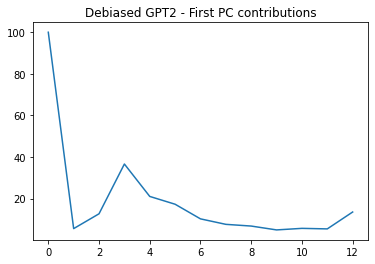

Second PCs [8.195296e-13, 4.258931, 6.079664, 8.500664, 7.6632037, 7.608705, 5.784653, 4.347113, 4.1528354, 3.2562428, 3.5082984, 3.1522706, 4.4442253]


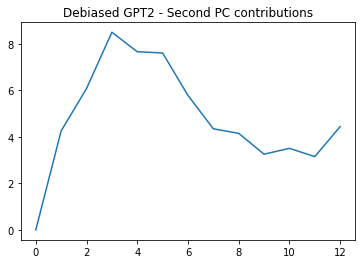

Third PCs [3.5527137e-13, 3.6544151, 4.3040395, 4.3287153, 4.6384354, 4.745661, 3.80763, 3.2814593, 3.0708625, 2.5096312, 2.6420105, 2.3025894, 3.1859198]


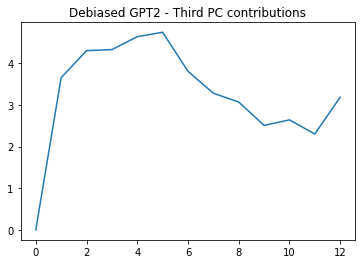

<Figure size 432x288 with 0 Axes>

In [56]:
ev = [e/count*100 for e in ev]
ev3 = ev

first_pcs = [f[0] for f in ev3]
print('First PCs', first_pcs)
plotVariance(first_pcs, title='Debiased GPT2 - First PC contributions')

second_pcs = [f[1] for f in ev3]
print('Second PCs', second_pcs)
plotVariance(second_pcs, title='Debiased GPT2 - Second PC contributions')

third_pcs = [f[2] for f in ev3]
print('Third PCs', third_pcs)
plotVariance(third_pcs, title='Debiased GPT2 - Third PC contributions')

**Normal GPT2**

In [57]:

toxic_words = ht['Word'][:num_words]
ev = [0]*13
count = 0
# find toxic words and their sentences
for word in toxic_words:
  
  sents = wsentTox[word][:num_sents]
  print('word', word, 'num_sent', len(sents))
  sflag = False
  for sent in sents:
    if count % 10 == 0: print(count)
    # encoded_text = tokenizer(sent)
    encoded_text = tokenizer.encode_plus(
        sent, add_special_tokens=True, truncation=True,
        max_length=256, padding='max_length',
        return_attention_mask=True,
        return_tensors='pt')
    tox, attn_masks = encoded_text['input_ids'], encoded_text['attention_mask']
    ntox = tox.clone()
    tokens = list([tokenizer.convert_ids_to_tokens(i) for i in ntox][0])
    tokens = [tok[1:] if tok[0] == 'Ġ' else tok for tok in tokens]
    try:
      idx = tokens.index(word)
    except:
      print('PROBLEM!')
      # print(tokens)
      print(sent)
      continue
      # sflag = True
      # break

    ntox[0][idx] = 0

    encoded_T = {
        "input_ids": tox,
        "attention_mask": attn_masks
    }
    encoded_NT = {
        "input_ids": ntox,
        "attention_mask": attn_masks
    }
    principal_components, exp_variance = run_gpt2_algorithm(encoded_T, encoded_NT, layerGpt2, debias=False)

    for i in range(13):
      ev[i] += exp_variance[i]
    count += 1

  if sflag:
    break
print(count)
# print('ev[0]', ev[0])
# todo: Use BERTForSentenceClassification then check the classifier hidden output

# a = num_sent x 768
# b = 2 x 768 PCs
# inner = a . bT -> num_sent x 2
# inner . b -> num_sent x 768




word pussy num_sent 10
0
word whore num_sent 10
10
word bitch num_sent 10
20
word fuck num_sent 10
30
word asshole num_sent 10
40
word slut num_sent 10
50
word fucking num_sent 10
60
word cking num_sent 10
70
word fucked num_sent 10
80
word igger num_sent 10
90
100


First PCs [100.0, 86.20554, 70.905396, 54.297234, 49.09643, 43.148182, 40.955147, 39.11568, 37.457188, 35.641056, 34.34874, 35.0805, 49.209286]


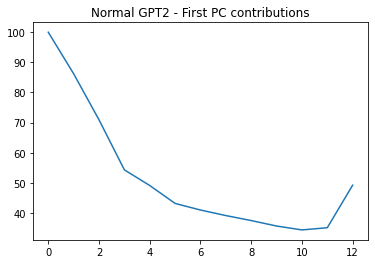

Second PCs [8.195296e-13, 7.8989835, 13.26383, 19.802603, 18.298786, 19.05163, 18.556013, 18.719439, 18.90347, 19.009811, 18.856026, 18.25159, 15.846679]


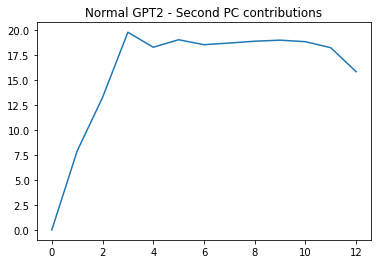

Third PCs [3.5527137e-13, 1.9536314, 6.0224476, 9.073983, 10.402219, 11.298372, 11.472561, 11.540216, 11.567588, 11.477645, 11.636531, 11.611438, 9.291172]


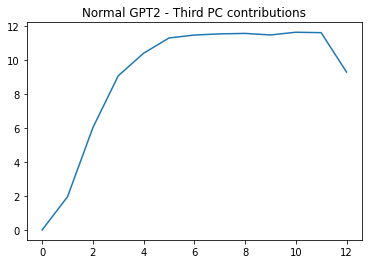

<Figure size 432x288 with 0 Axes>

In [58]:
ev = [e/count*100 for e in ev]
ev4 = ev

first_pcs = [f[0] for f in ev4]
print('First PCs', first_pcs)
plotVariance(first_pcs, title='Normal GPT2 - First PC contributions')

second_pcs = [f[1] for f in ev4]
print('Second PCs', second_pcs)
plotVariance(second_pcs, title='Normal GPT2 - Second PC contributions')

third_pcs = [f[2] for f in ev4]
print('Third PCs', third_pcs)
plotVariance(third_pcs, title='Normal GPT2 - Third PC contributions')